In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
import dnatools
from MLR import MLR
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14


/net/gs/vol3/software/modules-sw-python/2.7.3/pandas/0.14.0/Linux/RHEL6/x86_64/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


### Make directory to save results:

In [2]:
resultsdir = '../results/N6_A5SS_Model_Learning_Curves/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
figdir = '../figures/N6_A5SS_Model_Learning_Curves/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
#Choose if you want to actually save the plots:
SAVEFIGS = True

### Load the data

In [3]:
data = sio.loadmat('../data/Reads.mat')
# A5SS
A5SS_data = data['A5SS']
A5SS_reads = np.array(A5SS_data.sum(1)).flatten()
A5SS_data = np.array(A5SS_data.todense())
# Get minigenes with reads
A5SS_nn = find(A5SS_data.sum(axis=1))
A5SS_reads = A5SS_reads[A5SS_nn]
A5SS_data = A5SS_data[A5SS_nn]
A5SS_data = A5SS_data/A5SS_data.sum(axis=1)[:,newaxis]
A5SS_seqs = pd.read_csv('../data/A5SS_Seqs.csv',index_col=0).Seq[A5SS_nn]

### Get n-mer counts within each randomized region

I have written a function that return the counts of each n-mer within a sequence. With n minigenes the resulting matrix will be (n x $4^k$), for n-mers of length k. I make a matrix for each randomized region and then combine the two.

In [4]:
R1 = A5SS_seqs.str.slice(7,32)
R2 = A5SS_seqs.str.slice(50,75)
X = {}
for mer_len in range(3,8):
    X_r1 = dnatools.make_mer_matrix_no_pos(A5SS_seqs.str.slice(7-mer_len+1,32+mer_len-1),mer_len)
    X_r2 = dnatools.make_mer_matrix_no_pos(A5SS_seqs.str.slice(50-mer_len+1,75+mer_len-1),mer_len)
    X[mer_len] = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_r1,X_r2)))

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000

Our target that we want to predict is the fraction of splicing at $SD_1$. Y is (n x 2) with the first column reprenting $1-p(SD_1$) and the second column $p(SD_1$)

In [5]:
Y = scipy.matrix(np.array((1-A5SS_data[:,0],A5SS_data[:,0])).T)

I have already made split the data into training and test sets. This just loads the indices of each.

In [6]:
if False:
    inds = range(len(A5SS_seqs))
    shuffle(inds)
    train_set = inds[:int(len(inds)*0.9)]
    test_set = inds[int(len(inds)*0.9):]
else:
    train_set = np.loadtxt(resultsdir+'training_inds').astype(int)
    test_set = np.loadtxt(resultsdir+'test_inds').astype(int)

These are the data sizes and values of lambda that we will test. We will only test L1 regularization.

In [7]:
data_sizes = np.int64(10**arange(2,5.26,0.25))
lambdas = 10**arange(-1,-9,-1.)

Train all of the models:

In [8]:
models = {}
for L in lambdas:
    models[L] = {}
    print '-----------------Lambda:',L
    for mer_len in range(3,8):
        models[L][mer_len] = {}
        print '-----------------mer_len:',mer_len
        sys.stdout.flush()
        print '-----------------Data Size:',
        for data_size in data_sizes:
            print data_size,
            models[L][mer_len][data_size] = MLR(verbose=False)
            models[L][mer_len][data_size].fit(X[mer_len][train_set[:data_size]],
                                              Y[train_set[:data_size]],
                                              reg_type='L1',
                                              reg_lambda=L,
                                              maxit=5000)

-----------------Lambda: 0.1
-----------------mer_len: 3
-----------------Data Size: 100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 -----------------mer_len: 4
-----------------Data Size: 100 Failed to converge...
177 Failed to converge...
316 Failed to converge...
562 Failed to converge...
1000 Failed to converge...
1778 Failed to converge...
3162 Failed to converge...
5623 Failed to converge...
10000 17782 Failed to converge...
31622 56234 100000 Failed to converge...
177827 Failed to converge...
-----------------mer_len: 5
-----------------Data Size: 100 Failed to converge...
177 Failed to converge...
316 Failed to converge...
562 Failed to converge...
1000 Failed to converge...
1778 Failed to converge...
3162 Failed to converge...
5623 Failed to converge...
10000 Failed to converge...
17782 Failed to converge...
31622 Failed to converge...
56234 Failed to converge...
100000 Failed to converge...
177827 Failed to converge...
-----------------mer_len: 6
---

In [9]:
model_preds = {}
for L in lambdas:
    model_preds[L] = {}
    print '-----------------Lambda:',L
    for mer_len in range(3,8):
        model_preds[L][mer_len] = {}
        print '-----------------mer_len:',mer_len
        for data_size in data_sizes:
            print data_size,
            model_preds[L][mer_len][data_size] = models[L][mer_len][data_size].predict(X[mer_len][test_set])
        print ''

-----------------Lambda: 0.1
-----------------mer_len: 3
100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 
-----------------mer_len: 4
100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 
-----------------mer_len: 5
100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 
-----------------mer_len: 6
100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 
-----------------mer_len: 7
100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 
-----------------Lambda: 0.01
-----------------mer_len: 3
100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 
-----------------mer_len: 4
100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 
-----------------mer_len: 5
100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 
-----------------mer_len: 6
100 177 316 562 1000 1778 3162 5623 10000 17782 31622 56234 100000 177827 
--------------

In [10]:
R2s = {}
for L in lambdas:
    R2s[L] = {}
    for mer_len in range(3,8):
        R2s[L][mer_len] = {}
        print '-----------------mer_len:',mer_len
        for data_size in data_sizes:
            R2s[L][mer_len][data_size] = scipy.stats.pearsonr(model_preds[L][mer_len][data_size][:,1],np.array(Y)[test_set,1])[0]**2

-----------------mer_len: 3
-----------------mer_len: 4
-----------------mer_len: 5
-----------------mer_len: 6
-----------------mer_len: 7
-----------------mer_len: 3
-----------------mer_len: 4
-----------------mer_len: 5
-----------------mer_len: 6
-----------------mer_len: 7
-----------------mer_len: 3
-----------------mer_len: 4
-----------------mer_len: 5
-----------------mer_len: 6
-----------------mer_len: 7
-----------------mer_len: 3
-----------------mer_len: 4
-----------------mer_len: 5
-----------------mer_len: 6
-----------------mer_len: 7
-----------------mer_len: 3
-----------------mer_len: 4
-----------------mer_len: 5
-----------------mer_len: 6
-----------------mer_len: 7
-----------------mer_len: 3
-----------------mer_len: 4
-----------------mer_len: 5
-----------------mer_len: 6
-----------------mer_len: 7
-----------------mer_len: 3
-----------------mer_len: 4
-----------------mer_len: 5
-----------------mer_len: 6
-----------------mer_len: 7
-----------------mer

In [11]:
R2s = pd.Panel(R2s)

In [12]:
R2s.to_pickle(resultsdir+'Subsampling_R2.panel')

In [13]:
#R2s = pd.read_pickle(resultsdir+'Subsampling_R2.panel')

Plot the results (with the best L1 regularization parameter $\lambda$ ):

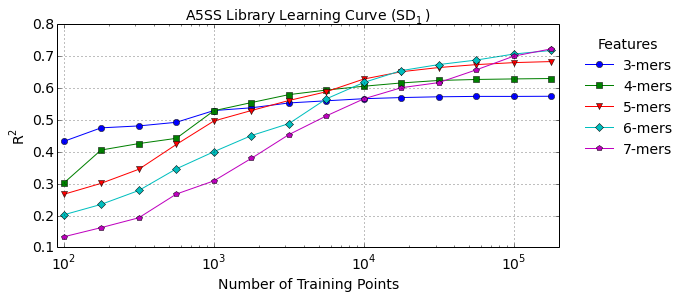

In [14]:
R2_maxes = R2s.apply(max,axis=0).iloc[:14]
fig = figure(figsize=(9,4))
ax = fig.add_subplot(111)
markers = ['o','s','v','D','p']
c = 0
for col in R2_maxes.columns:
    R2_maxes[col].plot(label=str(col)+'-mer',marker=markers[c])
    c+=1
#R2s.apply(max,axis=0).iloc[:14].plot(ax=ax,marker='o')
ax.set_xscale('log')
leg = legend([str(i)+'-mers' for i in range(3,8)],bbox_to_anchor=(1.25,1),numpoints=1,fontsize=fsize)
leg.get_frame().set_alpha(0)
leg.set_title('Features')
ax.set_xlabel('Number of Training Points',fontsize=fsize)
ax.set_ylabel('$R^2$',fontsize=fsize)
setp(leg.get_title(),fontsize=fsize)
ax.tick_params(labelsize=fsize)
ax.set_xlim(90,200000)
ax.set_title('A5SS Library Learning Curve ($SD_1$)',fontsize=fsize)
if SAVEFIGS:
    figname = 'A5SS_Learning_Curves'
    fig.savefig(figdir+figname+'.png',bbox_inches='tight', dpi = 300)
    fig.savefig(figdir+figname+'.pdf',bbox_inches='tight', dpi = 300)
    fig.savefig(figdir+figname+'.eps',bbox_inches='tight', dpi = 300)